# 2. 전처리 미션(1): 호텔 객실 취소 예측

주어진 예약 데이터를 통해 취소될 객실인지 예측을 하는 분석 모델을 생성해 봅니다.

👀 **데이터 컬럼 소개**

| 컬럼명                           | 설명                                                                 |
|----------------------------------|----------------------------------------------------------------------|
| **is_canceled**                  | 예약이 취소되었는지 여부를 나타내는 이진 변수 (0: 비취소, 1: 취소)    |
| **lead_time**                    | 예약 날짜와 실제 도착 날짜 사이의 일수                                |
| **stays_in_weekend_nights**      | 주말 동안 머무는 밤의 수                                              |
| **stays_in_week_nights**         | 평일 동안 머무는 밤의 수                                              |
| **is_repeated_guest**            | 반복 방문자인지 여부를 나타내는 이진 변수 (0: 처음 방문, 1: 반복 방문) |
| **previous_cancellations**       | 과거에 취소한 예약 횟수                                              |
| **previous_bookings_not_canceled** | 과거에 취소하지 않은 예약 횟수                                      |
| **booking_changes**              | 예약 후 변경된 횟수                                                  |
| **days_in_waiting_list**         | 대기 명단에 있는 일수                                                |
| **adr**                          | 평균 일일 요금 (Average Daily Rate)                                   |
| **deposit_type**                 | 보증금의 종류를 나타내는 범주형 변수                                   |

## 2.1 EDA(데이터 탐색)

### 2.1.1 데이터 불러오기

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 불러오기
hotel = pd.read_csv("./data/hotel.csv")
# 데이터 확인
hotel.head()

,is_canceled,deposit_type,lead_time,stays_in_weekend_nights,stays_in_week_nights,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr
0,0,No Deposit,105.0,2,5,NaN,0,0,1,0,131.50
1,0,No Deposit,303.0,2,2,NaN,0,0,0,0,73.95
2,0,No Deposit,33.0,2,3,0.0,0,0,0,0,NaN
3,0,No Deposit,48.0,0,1,0.0,0,0,1,0,80.30
4,0,No Deposit,216.0,4,7,0.0,0,0,2,0,60.90


### 2.1.2 데이터 개요 확인하기

💥 **MISSION**

> Dataframe의 info, describe 기능을 활용하여 주어진 데이터를 해석해보기

In [2]:
hotel_info = hotel.info()
hotel_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     20000 non-null  int64  
 1   deposit_type                    20000 non-null  object 
 2   lead_time                       19995 non-null  float64
 3   stays_in_weekend_nights         20000 non-null  int64  
 4   stays_in_week_nights            20000 non-null  int64  
 5   is_repeated_guest               19642 non-null  float64
 6   previous_cancellations          20000 non-null  int64  
 7   previous_bookings_not_canceled  20000 non-null  int64  
 8   booking_changes                 20000 non-null  int64  
 9   days_in_waiting_list            20000 non-null  int64  
 10  adr                             18937 non-null  float64
dtypes: float64(3), int64(7), object(1)
memory usage: 1.7+ MB


In [3]:
hotel_desc = hotel.describe()
hotel_desc

,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr
count,20000.00000,19995.000000,20000.000000,20000.000000,19642.000000,20000.000000,20000.000000,20000.000000,20000.000000,18937.000000
mean,0.12000,85.978345,0.892550,2.380400,0.038133,0.032900,0.169050,0.269400,1.983950,101.410239
std,0.32497,96.427240,0.952077,1.777345,0.191521,0.455552,1.502426,0.687566,15.927212,49.245097
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000
25%,0.00000,11.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,68.800000
50%,0.00000,51.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,94.500000
75%,0.00000,132.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,126.000000
max,1.00000,629.000000,13.000000,30.000000,1.000000,26.000000,66.000000,17.000000,379.000000,451.500000


🔬 **데이터 요약 결과 해석**


1. 📌 **is_canceled**
   - (값) 0-예약이 취소되지 않음/ 1-예약이 취소 됨 
   - (평균값) 0.12
   - ☞ **전체 예약 중 약 12%가 취소됨을 의미하고 이는 target 데이터의 불균형을 뜻함**

2. **lead_time**
   - (결측치) 5개
   - (평균) 85.98일/ (최소값)0일/ (최대값) 629일
   - ☞ **의미상 2년전 예약하는 경우는 없을 것 같기에 이상치 판단 필요**

3. **stays_in_weekend_nights**
	- (평균) 0.89일/ (최대값) 13일

4. **stays_in_week_nights**
	- (평균) 2.38일/ (최대값) 30일
 
5. **is_repeated_guest**
   - (값) 0-첫 고객/ 1-기존 고객
   - (결측치) 358개
   - (평균) 3.8
   - ☞ **예약 고객 중 약 3.8%가 기존 고객임을 의미하고 이는 feature 데이터의 불균형을 뜻함**

6. **previous_cancellations**
   - (평균) 0.03회/ (최대값) 26회
   - ☞ **취소를 26번한 것은 의미적으로도 어색하고 평균과 차이가 많이 나기 때문에 이상치인지 판단 필요**

7. **previous_bookings_not_canceled**
   - (평균) 0.17회/ (최대값) 66회

8. **booking_changes**	
	- (평균) 0.27회/ (최대값) 17회

9.  **days_in_waiting_list**
   - (평균) 1.98일/ (최대값) 379일
   - ☞ **평균과 차이가 많이 나기 때문에 이상치인지 판단 필요**

10. **adr (Average Daily Rate)**
   - (결측치) 1063개
   - (평균) 101.41/ (최소값) -6.38/ (최대값) 451.50
   - ☞ **요금이 음수일 수 없으니 이상치 확실함**

11. **deposit_type**
   - ☞ **범주형 데이터이기에 고유값 확인 필요**

### 2.1.3 시각화

**1. 수치형 변수 시각화**

💥 **MISSION**

> list에 수치형 변수들을 정의해보기

In [4]:
# 수치형
continuous_columns = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 
                      'previous_cancellations', 'previous_bookings_not_canceled', 
                      'booking_changes', 'days_in_waiting_list', 'adr']

📍 **히스토그램**
- 수치형 변수들을 히스토그램으로 시각하여 이상치에 대한 판단

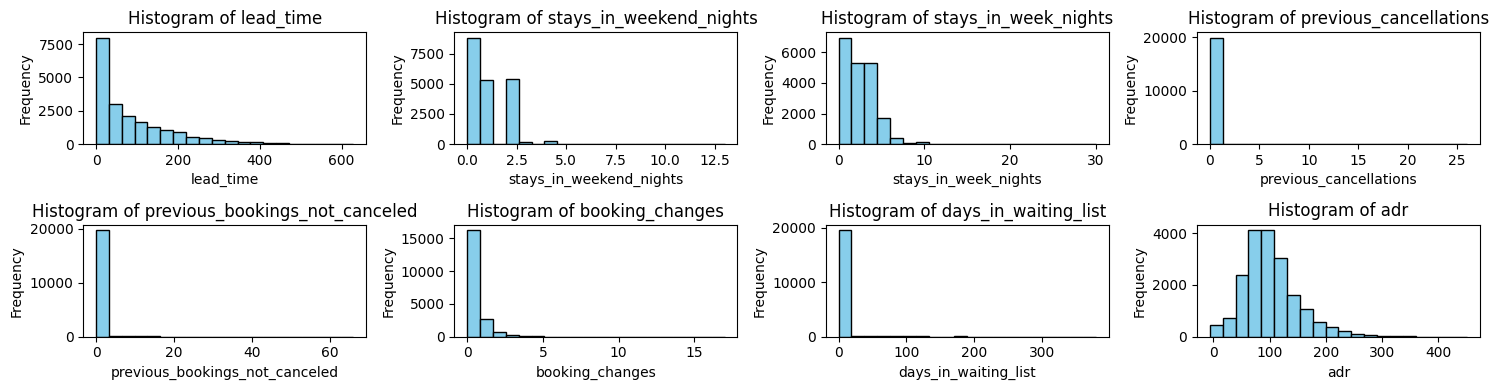

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 4))

for i, column in enumerate(continuous_columns):

    row = i // 4
    col = i % 4
    hotel[column].plot(kind='hist', bins=20, ax=axes[row, col], color='skyblue', edgecolor='black')
    axes[row, col].set_title(f'Histogram of {column}')
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('Frequency')

plt.tight_layout()

plt.show()

📍 **상자 그림**
- 히스토그램으로 분포를 파악해보았지만 이상치를 완벽하게 구분해 낼 수 없기에 상자 그림으로 이상치를 명확히 판단

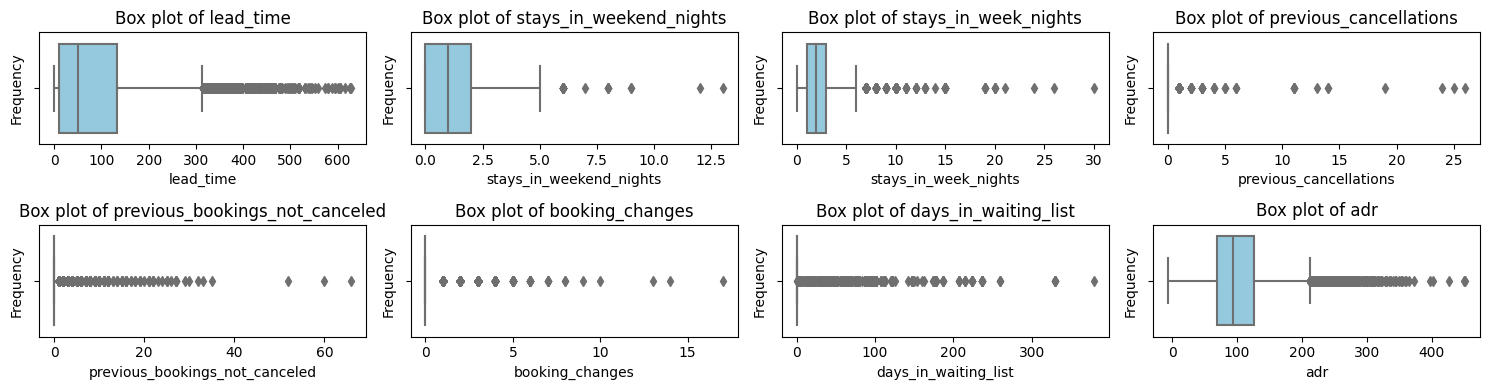

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 4))

for i, column in enumerate(continuous_columns):

    row = i // 4
    col = i % 4
    sns.boxplot(x=hotel[column], ax=axes[row, col], color='skyblue')
    axes[row, col].set_title(f'Box plot of {column}')
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

🔬 **수치형 변수 시각화 결과 해석**

- 상자 그림으로 표현시 모든 변수에서 이상치를 포함하고 있음
- 데이터 상으로는 이상치로 보이나 연속적으로 나타나있기 때문에 업무적으로는 이상치가 아닐 수 있음
- 각 변수에서 너무 동떨어진 몇개의 포인트만을 제거하는 보수적인 이상치 제거 방식 적용

**2. 범주형 변수 시각화**

💥 **MISSION**

> list에 범주형 변수들을 정의해보기

In [7]:
categorical_columns = ['is_canceled', 'deposit_type', 'is_repeated_guest']

📍 **막대그래프**

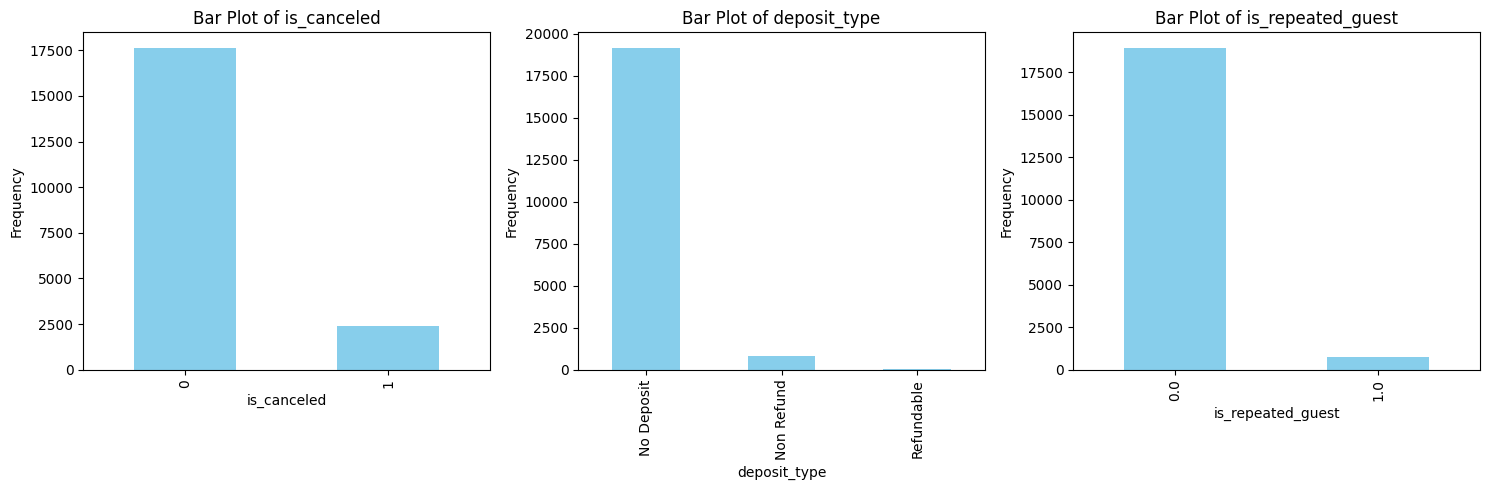

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for i, column in enumerate(categorical_columns):

    hotel[column].value_counts().sort_index().plot(kind='bar', ax=axes[i], color='skyblue')
    axes[i].set_title(f'Bar Plot of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

🔬 **범주형 변수 시각화 결과 해석**

- 모든 범주형 변수가 불균형임을 확인
- deposit_type은 범주형 변수처리 필요

**3. 그룹별 평균 시각화**
- 분류 문제일 경우 그룹별로 데이터를 시각화하여 파악하는 작업이 효과적일 수 있음

In [9]:
# 그룹별 평균
is_canceled = hotel.groupby('is_canceled').mean()
is_canceled

,lead_time,stays_in_weekend_nights,stays_in_week_nights,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr
is_canceled,,,,,,,,,
0,78.420290,0.888750,2.361080,0.041481,0.013068,0.189886,0.293409,1.737443,101.034845
1,141.388333,0.920417,2.522083,0.013577,0.178333,0.016250,0.093333,3.791667,104.162354


📍 **그룹별 막대 그래프**

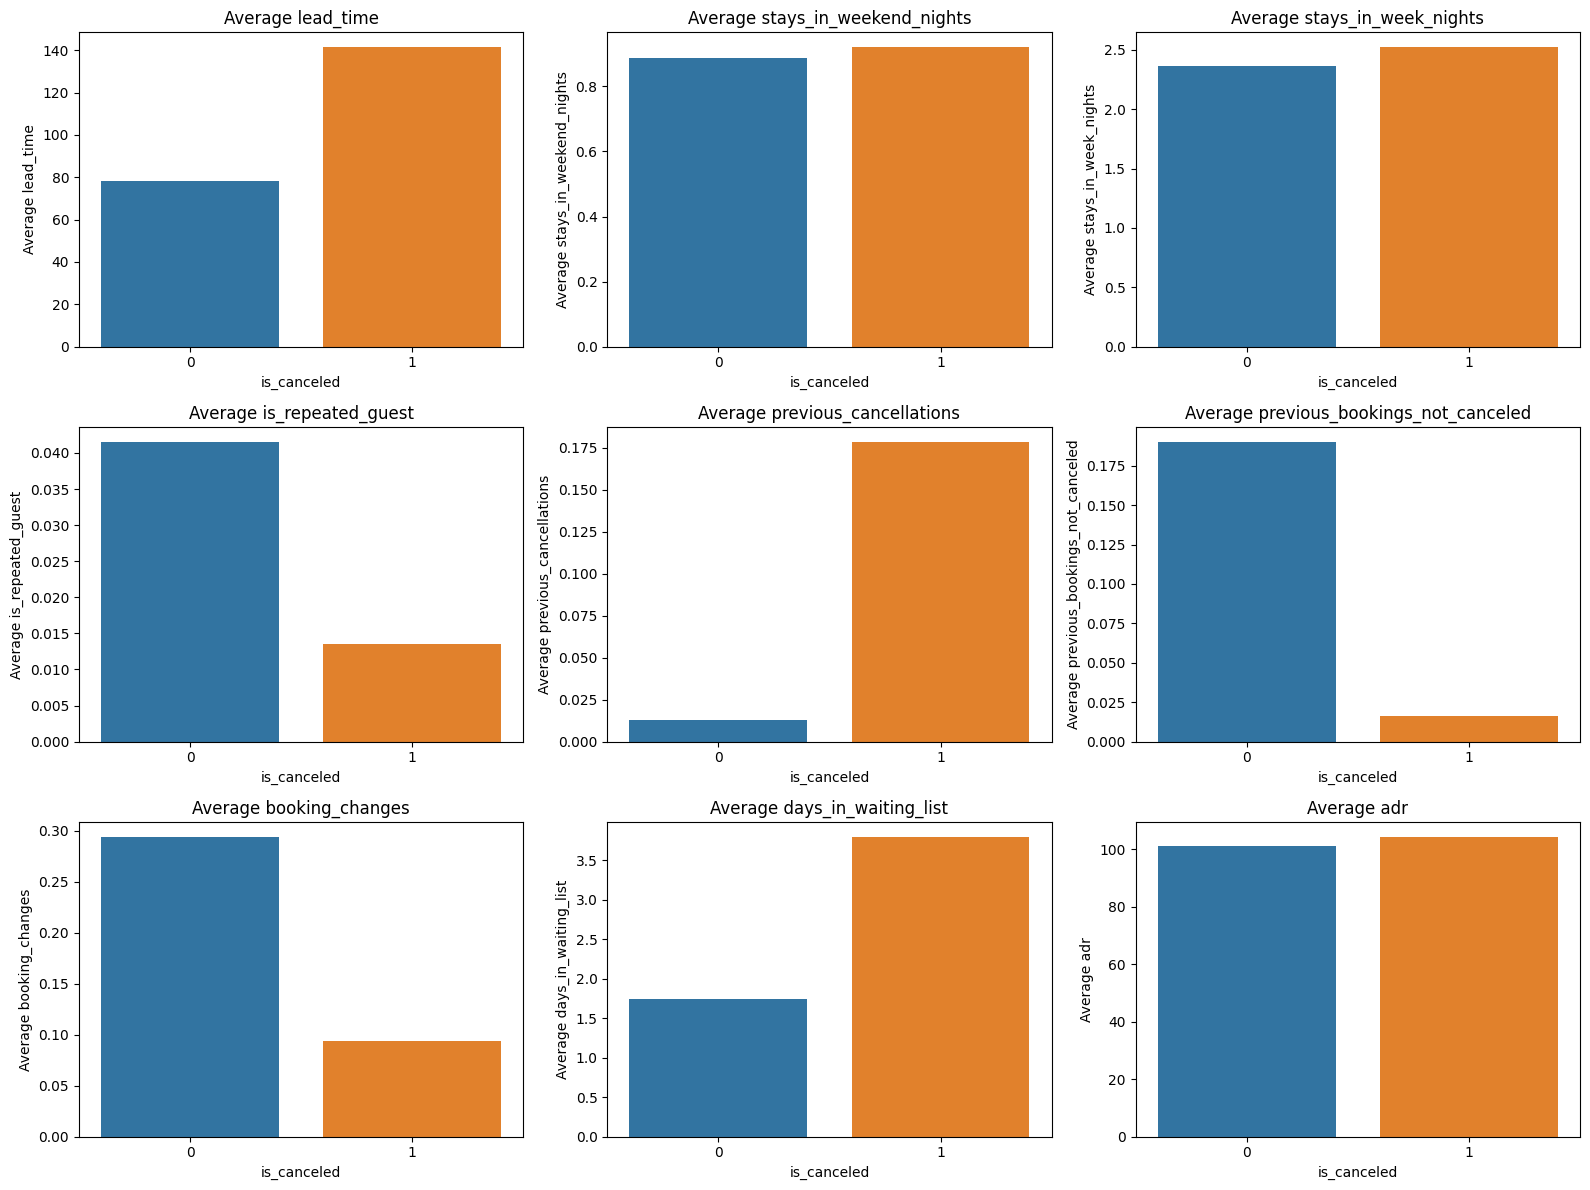

In [10]:
# 그룹별 막대 그래프
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

columns = is_canceled.columns.to_list()

for i, column in enumerate(columns):
    row = i // 3
    col = i % 3
    sns.barplot(x=is_canceled.index, y=column, data=is_canceled, ax=axes[row, col])
    axes[row, col].set_title(f'Average {column}')
    axes[row, col].set_xlabel("is_canceled")
    axes[row, col].set_ylabel(f'Average {column}')

plt.tight_layout()
plt.show()

🔬 **그룹별 평균 시각화 결과 해석**

- 예약 취소하지 않음/ 예약 취소 간의 그룹별 평균이 차이가 클 수록 분류에 영향을 많이 미칠 것으로 보임
- 모델의 성능이 좋지 못하면 그룹간 평균 차이가 없는 데이터를 피쳐에서 삭제해보는 방법 고려

## 2.2 데이터 전처리

### 2.2.1 결측치 탐색 및 처리

**1. 결측치 탐색**

💥 **MISSION**

> 컬럼별 결측치의 개수를 확인해보자

In [11]:
hotel.isna().sum()

is_canceled                          0
deposit_type                         0
lead_time                            5
stays_in_weekend_nights              0
stays_in_week_nights                 0
is_repeated_guest                  358
previous_cancellations               0
previous_bookings_not_canceled       0
booking_changes                      0
days_in_waiting_list                 0
adr                               1063
dtype: int64

📍**결측치 비율 확인**

In [12]:
for col in hotel.columns:
    if hotel[col].isna().sum() > 0:
        print("*"*15)
        print("결측치 컬럼 :", col)
        print("결측치 비율 : {}%".format(hotel[col].isna().sum()/len(hotel)*100))

***************
결측치 컬럼 : lead_time
결측치 비율 : 0.025%
***************
결측치 컬럼 : is_repeated_guest
결측치 비율 : 1.79%
***************
결측치 컬럼 : adr
결측치 비율 : 5.315%


🔬 **결측치 탐색 결과 해석**

- lead_time 결측치 비율이 작기에 제거해도 무방해 보임
- is_repeated_guest는 시각화를 통해 대부분이 0이 었으니 0으로 대체하여도 무방해 보임
- adr은 수치형이기 때문에 평균값으로 대체
  
**2. 결측치 처리**

💥 **MISSION**

> lead_time, is_repeated_guest, adr 컬럼에 대해 근거를 가지고 결측치 처리해보기

In [13]:
hotel.dropna(subset=['lead_time'], axis=0, inplace=True)
hotel['is_repeated_guest'].fillna(0, inplace = True)
hotel['adr'].fillna(hotel['adr'].mean(), inplace = True)

- lead_time은 결측치의 비율이 낮기 때문에 단순 삭제
- is_repeated_guset는 시각화 결과 대부분이 0이었기에 대체
- adr은 수치형이기 때문에 평균으로 대체

📍 **결측치 처리 결과**

In [14]:
hotel.isna().sum()

is_canceled                       0
deposit_type                      0
lead_time                         0
stays_in_weekend_nights           0
stays_in_week_nights              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
booking_changes                   0
days_in_waiting_list              0
adr                               0
dtype: int64

### 2.2.2 이상치 탐색 및 처리

**1. 이상치 탐색**

📍 **IQR**

In [15]:
iqr_outliers = pd.DataFrame()

for column in continuous_columns:
    Q1 = hotel[column].quantile(0.25)
    Q3 = hotel[column].quantile(0.75)
    IQR = Q3 - Q1
    # IQR 기준으로 이상치 데이터 필터링
    outliers_in_column = hotel[((hotel[column] < (Q1 - 1.5 * IQR)) | (hotel[column] > (Q3 + 1.5 * IQR)))]
    # 이상치 데이터를 iqr_outliers 데이터프레임에 추가
    iqr_outliers = pd.concat([iqr_outliers, outliers_in_column], axis=0).drop_duplicates()

iqr_outliers    

,is_canceled,deposit_type,lead_time,stays_in_weekend_nights,stays_in_week_nights,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr
14,0,No Deposit,377.0,0,2,0.0,0,0,1,0,101.410702
85,0,No Deposit,422.0,0,4,0.0,0,0,6,0,90.000000
164,0,No Deposit,316.0,0,3,0.0,0,0,0,0,110.000000
170,0,No Deposit,377.0,0,2,0.0,0,0,0,0,115.000000
227,0,No Deposit,338.0,1,2,0.0,0,0,0,68,90.670000
...,...,...,...,...,...,...,...,...,...,...,...
19848,1,No Deposit,91.0,2,3,0.0,0,0,0,0,273.000000
19852,1,No Deposit,102.0,2,3,0.0,0,0,0,0,280.000000
19938,1,No Deposit,19.0,0,4,0.0,0,0,0,0,250.000000
19944,1,No Deposit,50.0,0,3,0.0,0,0,0,0,219.000000


📍 **상위 n%**

In [16]:
outliers = pd.DataFrame()

for column in continuous_columns:
    # 각 연속형 변수에 대해 상위 95%에 해당하는 임계값 계산
    threshold = hotel[column].quantile(0.99)
    # 임계값보다 큰 데이터만 필터링하여 이상치로 판단
    outliers_in_column = hotel[hotel[column] > threshold]
    # 이상치 데이터를 outliers 데이터프레임에 추가
    outliers = pd.concat([outliers, outliers_in_column], axis=0).drop_duplicates()
outliers

,is_canceled,deposit_type,lead_time,stays_in_weekend_nights,stays_in_week_nights,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr
85,0,No Deposit,422.0,0,4,0.0,0,0,6,0,90.00
279,0,No Deposit,518.0,2,1,0.0,0,0,0,0,112.67
355,0,No Deposit,434.0,2,1,0.0,0,0,0,0,112.67
399,0,No Deposit,414.0,0,2,0.0,0,0,0,0,122.40
670,0,No Deposit,451.0,0,3,0.0,0,0,0,0,112.67
...,...,...,...,...,...,...,...,...,...,...,...
19686,1,No Deposit,22.0,2,5,0.0,0,0,1,0,262.00
19800,1,No Deposit,295.0,1,3,0.0,0,0,0,0,297.00
19811,1,No Deposit,20.0,0,2,0.0,0,0,0,0,299.00
19848,1,No Deposit,91.0,2,3,0.0,0,0,0,0,273.00


💥 **MISSION**

> IQR 방식과 n% 방식의 이상치 비율을 확인해보기

In [17]:
print("이상치 비율 iqr:", len(iqr_outliers)/len(hotel)*100)
print("이상치 비율 n%:", len(outliers)/len(hotel)*100)

이상치 비율 iqr: 26.831707926981746
이상치 비율 n%: 4.401100275068767


🔬 **이상치 탐색 결과 해석**

- 시각화를 통해 이상치로 보여도 데이터들이 연속적으로 존재하여 업무적으로는 이상치가 아닐 수 있음을 확인
- iqr 방식을 수행하면 너무 많은 데이터가 제거됨
- 비즈니스 로직을 모르기 때문에 보수적으로 이상치 제거

**2. 이상치 제거**

In [18]:
print("원본 데이터셋 개수", len(hotel))
for column in continuous_columns:
    # 각 연속형 변수에 대해 상위 percent 95%에 해당하는 임계값 계산
    threshold = hotel[column].quantile(0.99)
    # 임계값보다 작은 데이터만 필터링
    hotel = hotel[hotel[column] <= threshold]
print("이상치 처리 후 개수", len(hotel))    

원본 데이터셋 개수 19995
이상치 처리 후 개수 18885


### 2.2.3 범주형 변수 처리

**1. 인코딩**

💥 **MISSION**

> deposit_type에 대해 알맞은 범주형 변수 처리 해보기

In [19]:
# hotel은 순서형 변수가 아닌 명목형 변수이므로 원핫인코딩을 사용하여 변환

from sklearn.preprocessing import OneHotEncoder

# 원핫 인코딩 객체 생성 및 학습
oh = OneHotEncoder(sparse_output=False)
oh.fit(hotel[['deposit_type']])

# 원핫 인코딩 수행
oh_encoded = oh.transform(hotel[['deposit_type']])

# 데이터프레임으로 변환, 열 이름 지정
oh_hotel = pd.DataFrame(oh_encoded.astype('int'), columns=oh.get_feature_names_out(['deposit_type']), index=hotel.index)

oh_hotel

,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
19995,0,1,0
19996,0,1,0
19997,0,1,0
19998,1,0,0


**2. 데이터 병합**

💥 **MISSION**

> hotel 데이터에서 변환을 수행한 deposit_type 컬럼은 삭제하고, 인코딩 수행한 변수를 열 기준으로 concat 해보기

In [20]:
hotel = pd.concat([hotel.drop('deposit_type', axis=1), oh_hotel], axis=1)
hotel

,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable
0,0,105.0,2,5,0.0,0,0,1,0,131.500000,1,0,0
1,0,303.0,2,2,0.0,0,0,0,0,73.950000,1,0,0
2,0,33.0,2,3,0.0,0,0,0,0,101.410702,1,0,0
3,0,48.0,0,1,0.0,0,0,1,0,80.300000,1,0,0
4,0,216.0,4,7,0.0,0,0,2,0,60.900000,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,1,89.0,2,2,0.0,0,0,0,0,62.000000,0,1,0
19996,1,101.0,0,3,0.0,0,0,0,0,130.000000,0,1,0
19997,1,277.0,1,2,0.0,0,0,0,0,100.000000,0,1,0
19998,1,0.0,0,1,0.0,0,0,0,0,209.000000,1,0,0


🔬 **범주형 변수처리 결과 해석**

- deposit_type에 3개의 범주형 데이터가 있었고, 이를 원핫 인코딩을 통해 변환
- 3개의 범주형 데이터를 3개의 컬럼으로 나타내게 변환하고 이를 원본 데이터에 병합

### 2.2.4 데이터 분할

💥 **MISSION**

> hotel 데이터를 train(0.7)/ validation(0.2)/ test(0.1) 비율로 분할 해보기

In [21]:
from sklearn.model_selection import train_test_split

# 데이터 분할
train_data, test_data = train_test_split(hotel, test_size = 0.2, random_state=1004, stratify=hotel['is_canceled'])
validation_data, test_data = train_test_split(test_data, test_size = 0.5, random_state=1004, stratify=test_data['is_canceled'])

train_data.reset_index(drop=True, inplace=True)
validation_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

print('train data :', train_data.shape)
print('validation data :', validation_data.shape)
print('test data :', test_data.shape)

train data : (15108, 13)
validation data : (1888, 13)
test data : (1889, 13)


### 2.2.5 데이터 스케일링

**1. 데이터 범위 확인**

💥 **MISSION**

> train_data의 요약 통계 정보를 확인해보기

In [22]:
train_data.describe()

,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable
count,15108.000000,15108.000000,15108.000000,15108.000000,15108.000000,15108.000000,15108.000000,15108.000000,15108.000000,15108.000000,15108.000000,15108.000000,15108.000000
mean,0.116428,80.966773,0.865568,2.289515,0.028925,0.015753,0.049709,0.235637,0.632645,100.235385,0.960882,0.037861,0.001258
std,0.320749,88.131655,0.880643,1.518703,0.167602,0.124524,0.334039,0.556417,5.640655,44.318471,0.193883,0.190866,0.035442
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000,0.000000
25%,0.000000,10.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,72.000000,1.000000,0.000000,0.000000
50%,0.000000,49.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,96.900000,1.000000,0.000000,0.000000
75%,0.000000,125.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,122.725000,1.000000,0.000000,0.000000
max,1.000000,409.000000,4.000000,8.000000,1.000000,1.000000,4.000000,3.000000,69.000000,252.000000,1.000000,1.000000,1.000000


🔬 **데이터 범위 확인 결과 해석**

- lead_time, days_in_waiting_list, adr 변수가 다른 값에 비해 큰값을 가지고 있음을 확인

**2. 스케일링 수행(훈련 데이터)**

💥 **MISSION**

> train_data에 알맞은 스케일링 수행해보기

In [23]:
# 분류 분석이기에 standard scaling을 사용하여 데이터 스케일링
from sklearn.preprocessing import StandardScaler

scale_columns = ['lead_time', 'days_in_waiting_list', 'adr']

StdScaler = StandardScaler()
# Train 데이터의 fitting과 스케일링
StdScaler.fit(train_data[scale_columns])
scaled_data = StdScaler.transform(train_data[scale_columns])

# 데이터프레임 변환
scaled_df = pd.DataFrame(scaled_data, columns=scale_columns)
scaled_train_data = pd.concat([train_data.drop(scale_columns, axis=1), scaled_df], axis=1)
scaled_train_data.head()

,is_canceled,stays_in_weekend_nights,stays_in_week_nights,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,lead_time,days_in_waiting_list,adr
0,1,0,3,0.0,0,0,0,1,0,0,1.293939,-0.112162,0.378289
1,0,1,3,0.0,0,0,1,1,0,0,-0.839304,-0.112162,0.220336
2,0,2,5,0.0,0,0,0,1,0,0,0.510994,-0.112162,0.952109
3,0,1,5,0.0,0,0,1,1,0,0,-0.408116,-0.112162,2.118704
4,1,2,2,0.0,0,0,0,0,1,0,3.540652,-0.112162,-0.637123


**3. 스케일링 적용(검증, 테스트 데이터)**

In [24]:
# 검증용 데이터 스케일링 적용
scaled_data = StdScaler.transform(validation_data[scale_columns])
scaled_df = pd.DataFrame(scaled_data, columns=scale_columns)
scaled_val_df = pd.concat([validation_data.drop(scale_columns, axis=1), scaled_df], axis=1)

scaled_val_df.head()

,is_canceled,stays_in_weekend_nights,stays_in_week_nights,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,lead_time,days_in_waiting_list,adr
0,0,2,1,0.0,0,0,1,1,0,0,-0.793916,-0.112162,-0.118135
1,0,2,3,0.0,0,0,0,1,0,0,-0.827957,-0.112162,0.026521
2,1,2,3,0.0,0,0,0,1,0,0,-0.294646,-0.112162,0.378289
3,1,0,3,0.0,0,0,0,1,0,0,0.204624,-0.112162,1.150001
4,0,0,1,0.0,0,0,0,1,0,0,-0.918733,-0.112162,-0.073006


In [25]:
# 테스트 데이터 스케일링 적용
scaled_data = StdScaler.transform(test_data[scale_columns])
scaled_df = pd.DataFrame(scaled_data, columns=scale_columns)
scaled_test_df = pd.concat([test_data.drop(scale_columns, axis=1), scaled_df], axis=1)

scaled_test_df.head()

,is_canceled,stays_in_weekend_nights,stays_in_week_nights,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,lead_time,days_in_waiting_list,adr
0,0,0,3,0.0,0,0,0,1,0,0,0.091153,-0.112162,-0.088801
1,0,1,1,0.0,0,0,1,1,0,0,-0.328687,-0.112162,1.312467
2,0,2,5,0.0,0,0,0,1,0,0,-0.181176,-0.112162,-0.953029
3,0,0,2,1.0,0,1,0,1,0,0,-0.918733,-0.112162,-0.456605
4,0,2,2,0.0,0,0,0,1,0,0,0.352135,-0.112162,-0.027876


### 2.2.6 데이터 불균형 문제 처리

**1. Target 불균형 확인**

💥 **MISSION**

> train_data에서 Target인 is_canceled의 비율을 확인해보기

In [26]:
ratio0 = round(len(train_data[train_data['is_canceled']==0])/len(train_data)*100, 2)
ratio1 = round(len(train_data[train_data['is_canceled']==1])/len(train_data)*100, 2)
print('0 비율: {}%'.format(ratio0))
print('1 비율: {}%'.format(ratio1))

0 비율: 88.36%
1 비율: 11.64%


**2. 오버샘플링 수행**

💥 **MISSION**

> is_canceled 컬럼을 기준으로 오버샘플링 수행해보기

In [27]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# 오버샘플링 수행
oversample = RandomOverSampler() 

# 데이터 분할
x = scaled_train_data.drop('is_canceled', axis=1)
y = scaled_train_data['is_canceled']

x_over, y_over = oversample.fit_resample(x, y)
print(Counter(y_over))

Counter({1: 13349, 0: 13349})


🔬 **오버샘플링 결과 해석**

- 오버샘플링을 통해 0과 1의 비율을 동등하게 만듦

## 2.3 예측 모델 생성

### 2.3.1 분류 분석 모델 학습

**1. 선형 모델 생성 및 학습**

📍 **Support Vector Classification**

In [31]:
from sklearn.svm import SVC

svc = SVC() # 선형 커널 사용
svc.fit(x_over, y_over)

print('train 정확도 :', svc.score(x_over, y_over))

train 정확도 : 0.7047344370364821


**2. 트리기반 모델 생성 및 학습**

📍 **RandomForestClassifier**

In [30]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=1004)
rf.fit(x_over, y_over)

print('train 정확도 :', rf.score(x_over, y_over))

train 정확도 : 0.9937823057906959


### 2.3.2 분석 모델 성능 평가

분석 수행시 validation 데이터로 평가를 하며 모델의 파라미터 혹은 변수를 수정하는 튜닝 과정을 거친 뒤, test 데이터로 평가합니다. 이번 실습에서는 튜닝은 생략하고 validation 데이터와 test 데이터를 함께 test 데이터로 구성하여 최종 평가를 수행합니다.

**1. 데이터 병합**

In [32]:
# 행 기준으로 병합
total_test_data = pd.concat([scaled_val_df, scaled_test_df], axis=0)
total_test_data.reset_index(drop=True, inplace=True)
total_test_data.head()

,is_canceled,stays_in_weekend_nights,stays_in_week_nights,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,lead_time,days_in_waiting_list,adr
0,0,2,1,0.0,0,0,1,1,0,0,-0.793916,-0.112162,-0.118135
1,0,2,3,0.0,0,0,0,1,0,0,-0.827957,-0.112162,0.026521
2,1,2,3,0.0,0,0,0,1,0,0,-0.294646,-0.112162,0.378289
3,1,0,3,0.0,0,0,0,1,0,0,0.204624,-0.112162,1.150001
4,0,0,1,0.0,0,0,0,1,0,0,-0.918733,-0.112162,-0.073006


**2. 데이터 분할**

In [35]:
X_test = total_test_data.drop('is_canceled', axis=1)
y_test = total_test_data['is_canceled'].values

**3. 성능 평가**

📍 **Confusion Matrix**

In [40]:
from sklearn.metrics import classification_report

# svc 모델 성능 평가
print('SVC 성능평가')
y_pred=svc.predict(X_test)
print(classification_report(y_test, y_pred))
print('test 정확도 :', svc.score(X_test, y_test))

# rf 모델 성능 평가
print('RF 성능평가')
y_pred=rf.predict(X_test)
print(classification_report(y_test, y_pred))
print('test 정확도 :', rf.score(X_test, y_test))

SVC 성능평가
              precision    recall  f1-score   support

           0       0.94      0.81      0.87      3337
           1       0.29      0.58      0.38       440

    accuracy                           0.78      3777
   macro avg       0.61      0.70      0.63      3777
weighted avg       0.86      0.78      0.81      3777

test 정확도 : 0.7834259994704792
RF 성능평가
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      3337
           1       0.57      0.43      0.49       440

    accuracy                           0.90      3777
   macro avg       0.75      0.70      0.72      3777
weighted avg       0.89      0.90      0.89      3777

test 정확도 : 0.895419645221075
